## Functions and pathes

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
#from skimage import data
from skimage.filters import gaussian
#from skimage.segmentation import active_contour
import tifffile
import cv2
import random
from skimage.morphology import remove_small_objects, binary_closing, disk, binary_opening
from skimage.segmentation import morphological_geodesic_active_contour, flood_fill
from skimage.filters import sobel
#from skimage.segmentation import inverse_gaussian_gradient

In [2]:
tiff_dir = r"\\CaspiLab-Backup\Computers-Backup\CaspiLab-Micro\DiskF\Mirit\SmartHeart snapshot and video troublshooting\trouble 3\Day 7 CF;CM with DMEMF12\tif II\spont"

tiff_path = "SH_CF;CM_1Hz_G4_01current001.tif"
tiff_path_1 = "SH_CF;CM_1Hz_G4_01current001.tif"
tiff_path_2 ="SmartHeart_G2_75K_Spont_002current001.tif"

tiff_path_1_exp_1HZ = "SH II_1Hz_D4_003current001.tif"
tiff_path_2_exp_1HZ = "SH II_1Hz_C4_009current001.tif"
tiff_path_3_exp_1HZ = "SH II_1Hz_A4_001current001.tif"
tiff_path_4_exp_2HZ = "SH II_2Hz_A4_007current001.tif"

In [3]:
def sharpen_edges(img):
    blur = (img - cv2.GaussianBlur(img,(5,5),0)) 
    details = img - blur
    return img + details

In [4]:
def get_img(file,frame_number):
    tiff_stack = tifffile.imread(file)  # Load as a stack of images
    num = len(tiff_stack)
    frame_number = frame_number
    img = tiff_stack[frame_number]
    image_normalized = (img - img.min()) / (img.max() - img.min()) * 255
    image = image_normalized.astype(np.uint8)
    return image

In [5]:
def calculate_strain_stress_from_max_area(current_area_px, max_area_px, youngs_modulus_kpa=13, pixel_size_nm=650):
    """
    Calculates strain and stress based on max area and current area.

    :param current_area_px: float, current area in pixels²
    :param max_area_px: float, maximum observed area in pixels²
    :param youngs_modulus_kpa: float, Young’s modulus in kPa
    :param pixel_size_nm: float, pixel size in nanometers
    :return: tuple (real_area_mm², strain, stress_kpa)
    """
    pixel_size_mm = pixel_size_nm / 1e6
    real_area_mm2 = current_area_px * (pixel_size_mm ** 2)
    max_area_mm2 = max_area_px * (pixel_size_mm ** 2)
    
    strain = (max_area_mm2 - real_area_mm2) / max_area_mm2
    stress_kpa = youngs_modulus_kpa * strain
    
    return real_area_mm2, strain, stress_kpa


In [6]:
def preprocess_image(img, display=False):
    """
    Preprocess the input image: sharpen, blur, Sobel, threshold, and clean.

    Parameters:
        img (ndarray): Grayscale input image.
        display (bool): If True, display intermediate results.

    Returns:
        cleaned (ndarray): Preprocessed binary mask.
    """
    if len(img.shape) == 3:
        img = rgb2gray(img)  # Convert to grayscale
        
    img = sharpen_edges(img)

    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(img, (5, 5), sigmaX=3)

    # Sobel edge detection
    img_sobel = sobel(img_blur)

    # Convert to uint8
    img_sobel_uint8 = (img_sobel * 255).astype(np.uint8)

    # Otsu thresholding
    _, binary = cv2.threshold(img_sobel_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Clean binary mask
    cleaned = remove_small_objects(binary.astype(bool), min_size=70)
    cleaned = binary_closing(cleaned, footprint=disk(10))

    if display:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(binary, cmap='gray')
        plt.title("Otsu Threshold on Sobel")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cleaned, cmap='gray')
        plt.title("Cleaned Binary Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return cleaned

In [7]:
def compute_flood_fill_area(cleaned, display=False):
    """
    Apply flood fill from the center and calculate the filled area.

    Parameters:
        cleaned (ndarray): Preprocessed binary mask.
        display (bool): If True, display the result.

    Returns:
        area_px (int): Pixel count of filled region.
    """
    seed_point = (cleaned.shape[0] // 2, cleaned.shape[1] // 2)
    filled_image = flood_fill(cleaned.astype(float), seed_point, new_value=0.5)
    area_px = np.sum(filled_image == 0.5)

    if display:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(cleaned, cmap='gray')
        plt.title('Original Binary Mask')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(filled_image, cmap='gray')
        plt.title('Flood Filled from Center')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return area_px

In [8]:
def display_filled_on_image(img, filled_image, fill_value=0.5):
    """
    Overlay the filled region on the original grayscale image.

    Parameters:
        img (ndarray): Original grayscale image.
        filled_image (ndarray): Image with filled region.
        fill_value (float): The value used to identify the filled region.
    """
    filled_mask = filled_image == fill_value

    # Convert grayscale image to RGB
    if img.ndim == 2:
        img_rgb = np.stack([img] * 3, axis=-1)
    else:
        img_rgb = img.copy()

    # Normalize for display if needed
    img_rgb = img_rgb.astype(np.float32)
    if img_rgb.max() > 1:
        img_rgb /= 255.0

    # Overlay red on filled region
    overlay = img_rgb.copy()
    overlay[filled_mask] = [1, 0, 0]  # Red

    # Display
    plt.imshow(overlay)
    plt.title("Flood-Filled Region on Image")
    plt.axis('off')
    plt.show()

In [9]:
start_time = time.time()
# Path to a specific TIFF file
file_path = os.path.join(tiff_dir, 'SH II_spont_C4_009current001.tif')

# Read the image
tiff_stack = tifffile.imread(file_path)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"loading the TIFF took {elapsed_time:.3f} seconds.")
# # Display it
# import matplotlib.pyplot as plt
# plt.imshow(image, cmap='gray')
# plt.title("Loaded TIFF Image")
# plt.axis('off')
# plt.show()
# #sampled_img = get_img(tiff_path_2_exp_1HZ,975)
# try_img = plt.imread(r"C:\Users\CaspiLab\Desktop\smarthreart - Dor's codes\SH_1Hz_E4_009current001.jpg")

loading the TIFF took 73.154 seconds.


## Choosing a file and set the lists 

In [10]:
areas_px = []
# tiff_name = tiff_path_2_exp_1HZ
# tiff_stack = tifffile.imread(tiff_name)  # Load as a stack of images

## pre-processing

In [11]:
import time
start_time = time.time()
for img in tiff_stack:
    cleaned = preprocess_image(img, display=False)
    areas_px.append(compute_flood_fill_area(cleaned, display=False))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"areas calculation took {elapsed_time:.3f} seconds.")

areas calculation took 300.315 seconds.


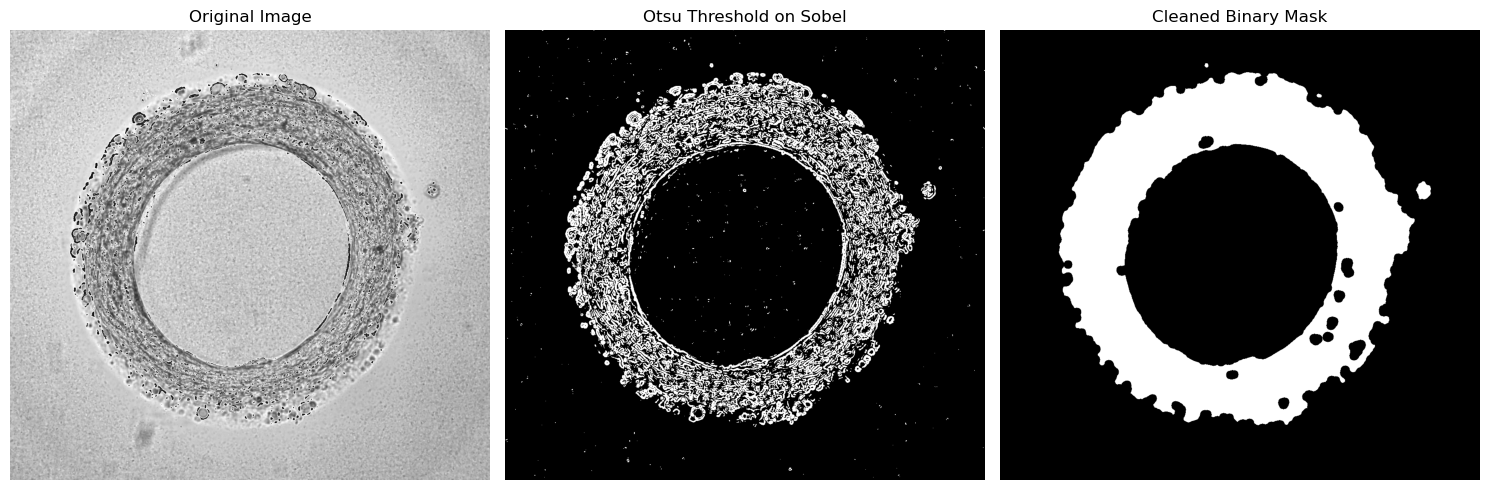

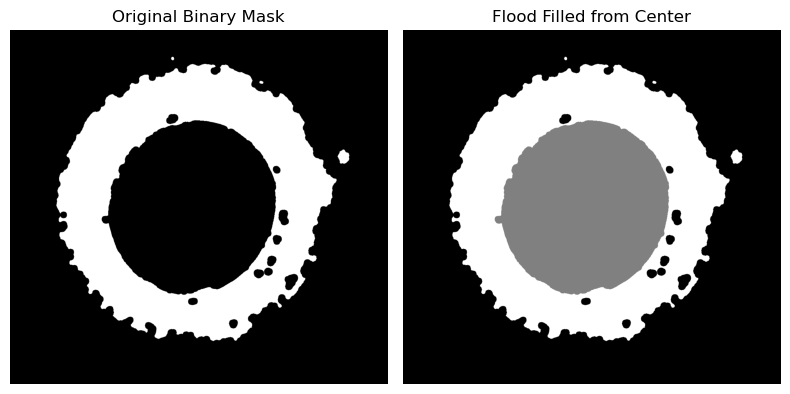

200561
0.957 seconds.


In [12]:
try_img = tiff_stack[255]
start_time = time.time()
clean = preprocess_image(try_img, display=True)
area =compute_flood_fill_area(clean, display=True)
print(area)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"{elapsed_time:.3f} seconds.")

## calculating stress and strain for each frame

In [13]:
max_area_px = max(areas_px)

results = []

for i, area_px in enumerate(areas_px):
    if area_px is not None:
        real_area_mm2, strain, stress_kpa = calculate_strain_stress_from_max_area(
            area_px, max_area_px, youngs_modulus_kpa=13
        )
        results.append({
            "frame": i,
            "area_px": area_px,
            "real_area_mm2": real_area_mm2,
            "strain": strain,
            "stress_kpa": stress_kpa
        })
    else:
        results.append({
            "frame": i,
            "area_px": None,
            "real_area_mm2": None,
            "strain": None,
            "stress_kpa": None
        })

df = pd.DataFrame(results)

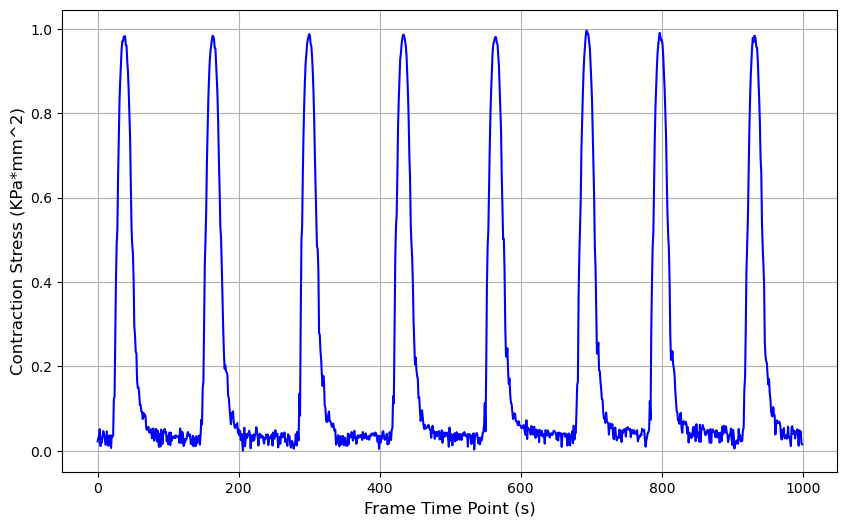

In [14]:
contraction_stress, frame_time_point = df['stress_kpa'] , df['frame'] # [mPa*mm^2] represent - load applied across a certain area, means [10^-9N or nN].
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point, contraction_stress, linestyle='-', color='b')
#plt.title(f'Contraction Stress vs Frame Time Point\nSource file: {tiff_name}', fontsize=14)
plt.xlabel('Frame Time Point (s)', fontsize=12)
plt.ylabel('Contraction Stress (KPa*mm^2)', fontsize=12)
plt.grid(True)
plt.show()

In [15]:
#df.to_csv("stress_2HZ_4_flood_fill.csv", index=False)

In [16]:
max_area_px

201183